# Определение пола человека по его имени
Работу выполнили студентки 2 курса Высшей школы ИТИС Грибанова Анастасия и Шафеева Дина, группа 11-803.

**Цель проекта:** научиться по имени, фамилии и отчеству человека определять его пол. 

Для достижения этой цели берутся данные 62609 человек и на их основе строятся различные модели.
Для работы берутся данные русскоязычного населения, из-за наличия у тех отчества, которое будет являться дополнительным параметром для анализа.

**Поля:** полями данных являются полные имена, а именно: фамилия, имя, отчество человека. Последнее поле в таблице - пол.

**Источник:** https://github.com/Rai220/MlSexDetector/blob/master/dataMini.csv

Прежде всего нам нужно импортировать все библиотеки, которые мы будем использовать в дальнейшем.

In [ ]:
import chardet
import pandas as pd
from statistics import mode
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

Теперь загрузим данные.

In [1]:
with open('C:/Users/Nastya/dataMini.csv', 'rb') as f:
    result = chardet.detect(f.readline()) 


data = pd.read_csv('C:/Users/Nastya/dataMini.csv', encoding=result['encoding'])
data.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М


In [2]:
data.shape

(62609, 4)

Узнаем, есть ли в данных пропущенные значения, с помощью функции isnull()

In [3]:
data.isnull().any().any()

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 4 columns):
ФАМИЛИЯ     62609 non-null object
ИМЯ         62609 non-null object
ОТЧЕСТВО    62579 non-null object
ПОЛ         62609 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


Воспользовавшись функцией info(), выяснили, что пропуски встречаются только в столбце «Отчество», и их не так много, всего 30, так что можем заменить их на самое часто встречающееся значение в этом столбце - моду. Найдем это значение.

In [5]:
print(data.mode()['ОТЧЕСТВО'])

0    АЛЕКСАНДРОВНА
Name: ОТЧЕСТВО, dtype: object


Подставляем эту моду ('Александровна') в пропущенные ячейки.

In [6]:
data = data.fillna('АЛЕКСАНДРОВНА')
print(data)

         ФАМИЛИЯ     ИМЯ       ОТЧЕСТВО ПОЛ
0        АБАБКОВ  СЕРГЕЙ       ИВАНОВИЧ   М
1          АБАЕВ  АНДРЕЙ  АЛЕКСАНДРОВИЧ   М
2        АБАЗОВА   ЕЛЕНА     НИКОЛАЕВНА   Ж
3       АБАКУМОВ  СЕРГЕЙ     ВАСИЛЬЕВИЧ   М
4       АБАКУМОВ  СЕРГЕЙ     ВАСИЛЬЕВИЧ   М
...          ...     ...            ...  ..
62604     ЖАРОВА  МАРИНА    АНАТОЛЬЕВНА   Ж
62605  СИРОТКИНА  ГАЛИНА     НИКОЛАЕВНА   Ж
62606    ЧУВИЛИН  СЕРГЕЙ     ВИКТОРОВИЧ   М
62607    БЕКАСОВ  МИХАИЛ     НИКОЛАЕВИЧ   М
62608     ЛЕЗОВА    ИННА     НИКОЛАЕВНА   Ж

[62609 rows x 4 columns]


Еще раз проверим наши данные на наличие пропущенных значений с помощью той же функции isnull().

In [7]:
data.isnull().any().any()

False

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 4 columns):
ФАМИЛИЯ     62609 non-null object
ИМЯ         62609 non-null object
ОТЧЕСТВО    62609 non-null object
ПОЛ         62609 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


Пропущенные данные успешно заполнились модой

   Наш алгоритм будет строиться на основе окончаний отчеств. Мы выяснили, что большинство отчеств оканчиваются на "ич", "лы", "на", "зы" и "ва". Из них первые два относятся к мужским отчествам, а последние к женским.

   Но при этом в выборке будут встречаться и отчества, которые не относятся к данным категориям, имеющие другие окончания.

   Чтобы узнать, к какому полу чаще всего относятся люди, имеющие такие отчества, мы прошлись по всем данным и посчитали сколько человек относится к мужскому полу, а сколько к женскому.

In [9]:
male = 0
female = 0
for index, row in data.iterrows():
    endOfLastname = row['ОТЧЕСТВО'][len(row['ОТЧЕСТВО'])-2:]
    if endOfLastname!='ИЧ' and endOfLastname!='ЛЫ' and endOfLastname!='НА' and endOfLastname!='ЗЫ' and endOfLastname!='ВА':
        if row['ПОЛ']=='М':
            male=male+1
        else:
            female=female+1
print("count of male = ", male, " count of female = ", female)

count of male =  195  count of female =  112


В результате мы выяснили, что мужчин 195, а женщин 112. Так как мужчин больше, мы решили причислять всех людей с отличными от нашей классификации окончаний отчествами к мужскому полу.

In [10]:
data['Pred'] = None
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 5 columns):
ФАМИЛИЯ     62609 non-null object
ИМЯ         62609 non-null object
ОТЧЕСТВО    62609 non-null object
ПОЛ         62609 non-null object
Pred        0 non-null object
dtypes: object(5)
memory usage: 2.4+ MB


Далее мы создали новый столбец для нашей модели, прошлись по всем данным и заполнили его.

In [11]:
for index, row in data.iterrows():
    endOfLastname = row['ОТЧЕСТВО'][len(row['ОТЧЕСТВО'])-2:]
    if endOfLastname=='НА' or endOfLastname=='ЗЫ' or endOfLastname=='ВА':
        row['Pred'] = 'Ж'
    else:
        row['Pred'] = 'М'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 5 columns):
ФАМИЛИЯ     62609 non-null object
ИМЯ         62609 non-null object
ОТЧЕСТВО    62609 non-null object
ПОЛ         62609 non-null object
Pred        62609 non-null object
dtypes: object(5)
memory usage: 2.4+ MB


In [12]:
data.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,Pred
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,М
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,М
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,Ж
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,М
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,М


In [13]:
data.tail()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,Pred
62604,ЖАРОВА,МАРИНА,АНАТОЛЬЕВНА,Ж,Ж
62605,СИРОТКИНА,ГАЛИНА,НИКОЛАЕВНА,Ж,Ж
62606,ЧУВИЛИН,СЕРГЕЙ,ВИКТОРОВИЧ,М,М
62607,БЕКАСОВ,МИХАИЛ,НИКОЛАЕВИЧ,М,М
62608,ЛЕЗОВА,ИННА,НИКОЛАЕВНА,Ж,Ж


In [14]:
accuracy = 0
for index, row in data.iterrows():
    if row['Pred']==row['ПОЛ']:
        accuracy=accuracy+1
print('accuracy is ', accuracy/len(data))

accuracy is  0.9963583510357936


Чтобы выяснить точность нашей модели, мы еще раз прошлись по всем данным и сравнили готовое значение пола с нашим прогнозом. Результат поделили на количество всех элементов. 

Итак, точность нашего алгоритма равняется 0,996.

Для сравнения воспользуемся методами машинного обучения. Для этого еще раз считаем данные, чтобы избавиться от изменений, которые мы внесли при предыдущей работе с ними.

In [15]:
with open('C:/Users/Nastya/dataMini.csv', 'rb') as f:
    result = chardet.detect(f.readline()) 


data1 = pd.read_csv('C:/Users/Nastya/dataMini.csv', encoding=result['encoding'])
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М


Прежде всего опять заполним пропущенные значения в столбце "Отчество" на чаще встречающееся - Александровна.

In [16]:
data1 = data1.fillna('АЛЕКСАНДРОВНА')
print(data1)

         ФАМИЛИЯ     ИМЯ       ОТЧЕСТВО ПОЛ
0        АБАБКОВ  СЕРГЕЙ       ИВАНОВИЧ   М
1          АБАЕВ  АНДРЕЙ  АЛЕКСАНДРОВИЧ   М
2        АБАЗОВА   ЕЛЕНА     НИКОЛАЕВНА   Ж
3       АБАКУМОВ  СЕРГЕЙ     ВАСИЛЬЕВИЧ   М
4       АБАКУМОВ  СЕРГЕЙ     ВАСИЛЬЕВИЧ   М
...          ...     ...            ...  ..
62604     ЖАРОВА  МАРИНА    АНАТОЛЬЕВНА   Ж
62605  СИРОТКИНА  ГАЛИНА     НИКОЛАЕВНА   Ж
62606    ЧУВИЛИН  СЕРГЕЙ     ВИКТОРОВИЧ   М
62607    БЕКАСОВ  МИХАИЛ     НИКОЛАЕВИЧ   М
62608     ЛЕЗОВА    ИННА     НИКОЛАЕВНА   Ж

[62609 rows x 4 columns]


Так как большинство методов машинного обучения может работать только с числовыми значениями, нам нужно изменить наши строковые данные. Для анализа имен достаточно иметь информацию об окончаниях всех частей ФИО. Для имени и фамилии нам будет достаточно последней буквы, а для отчества возьмем последние две.

In [17]:
data1['ФАМ_ОКОНЧ'] = None
data1['ИМЯ_ОКОНЧ'] = None
data1['ОТЧ_ОКОНЧ'] = None
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,None,None,None
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,None,None,None
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,None,None,None
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,None,None,None
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,None,None,None


In [18]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 7 columns):
ФАМИЛИЯ      62609 non-null object
ИМЯ          62609 non-null object
ОТЧЕСТВО     62609 non-null object
ПОЛ          62609 non-null object
ФАМ_ОКОНЧ    0 non-null object
ИМЯ_ОКОНЧ    0 non-null object
ОТЧ_ОКОНЧ    0 non-null object
dtypes: object(7)
memory usage: 3.3+ MB


In [19]:
for index, row in data1.iterrows():
    endOfSurname = row['ФАМИЛИЯ'][len(row['ФАМИЛИЯ'])-1]
    endOfName = row['ИМЯ'][len(row['ИМЯ'])-1]
    endOfLastname = row['ОТЧЕСТВО'][len(row['ОТЧЕСТВО'])-2:]
    row['ФАМ_ОКОНЧ'] = endOfSurname
    row['ИМЯ_ОКОНЧ'] = endOfName
    row['ОТЧ_ОКОНЧ'] = endOfLastname
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ


Создадим словари для конвертирования окончаний в числа. При этом 1 будет значить принадлежность к женскому полу, -1 - к мужскому, а 0 - неопределенные данные. Заполним этими значениями новые столбцы для кодировки окончаний, а все пропущенные значения заменим на 0.

In [20]:
data1['ФАМИЛИЯ_КОД'] = None
data1['ИМЯ_КОД'] = None
data1['ОТЧЕСТВО_КОД'] = None
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ,None,None,None
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ,None,None,None
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА,None,None,None
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,None,None,None
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,None,None,None


In [21]:
dct = {'А': 1, 'Я': 1, 'Н': -1, 'В': -1, 'Й': -1} 
data1['ФАМИЛИЯ_КОД'] = data1['ФАМ_ОКОНЧ'].map(dct)
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ,-1.0,None,None
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ,-1.0,None,None
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА,1.0,None,None
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,None,None
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,None,None


In [22]:
dct_third_name = {'ИЧ':-1, 'ЛЫ':-1, 'НА':1, 'ЗЫ':1, 'ВА':1}
data1['ОТЧЕСТВО_КОД'] = data1['ОТЧ_ОКОНЧ'].map(dct_third_name)
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ,-1.0,None,-1.0
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ,-1.0,None,-1.0
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА,1.0,None,1.0
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,None,-1.0
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,None,-1.0


In [23]:
dct_name = {'А':1, 'Я':1, 'М':-1, 'Й':-1, 'Н':-1, 'Т':-1, 'Р':-1}
data1['ИМЯ_КОД'] = data1['ИМЯ_ОКОНЧ'].map(dct_name)
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА,1.0,1.0,1.0
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0


In [24]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 10 columns):
ФАМИЛИЯ         62609 non-null object
ИМЯ             62609 non-null object
ОТЧЕСТВО        62609 non-null object
ПОЛ             62609 non-null object
ФАМ_ОКОНЧ       62609 non-null object
ИМЯ_ОКОНЧ       62609 non-null object
ОТЧ_ОКОНЧ       62609 non-null object
ФАМИЛИЯ_КОД     55897 non-null float64
ИМЯ_КОД         56206 non-null float64
ОТЧЕСТВО_КОД    62302 non-null float64
dtypes: float64(3), object(7)
memory usage: 4.8+ MB


In [25]:
data1 = data1.fillna(0)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62609 entries, 0 to 62608
Data columns (total 10 columns):
ФАМИЛИЯ         62609 non-null object
ИМЯ             62609 non-null object
ОТЧЕСТВО        62609 non-null object
ПОЛ             62609 non-null object
ФАМ_ОКОНЧ       62609 non-null object
ИМЯ_ОКОНЧ       62609 non-null object
ОТЧ_ОКОНЧ       62609 non-null object
ФАМИЛИЯ_КОД     62609 non-null float64
ИМЯ_КОД         62609 non-null float64
ОТЧЕСТВО_КОД    62609 non-null float64
dtypes: float64(3), object(7)
memory usage: 4.8+ MB


Таким же образом закодируем пол: женский - 1, мужской - -1.

In [26]:
data1['ПОЛ_КОД'] = None

In [27]:
dct_gender = {'Ж':1, 'М':-1}
data1['ПОЛ_КОД'] = data1['ПОЛ'].map(dct_gender)
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМ_ОКОНЧ,ИМЯ_ОКОНЧ,ОТЧ_ОКОНЧ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД,ПОЛ_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0,-1
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0,-1
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,А,А,НА,1.0,1.0,1.0,1
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0,-1
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,В,Й,ИЧ,-1.0,-1.0,-1.0,-1


Теперь можем удалить столбцы с окончаниями, так как они нам больше не нужны.

In [28]:
data1.drop(['ФАМ_ОКОНЧ', 'ИМЯ_ОКОНЧ', 'ОТЧ_ОКОНЧ'], axis='columns', inplace=True)
data1.head()

,ФАМИЛИЯ,ИМЯ,ОТЧЕСТВО,ПОЛ,ФАМИЛИЯ_КОД,ИМЯ_КОД,ОТЧЕСТВО_КОД,ПОЛ_КОД
0,АБАБКОВ,СЕРГЕЙ,ИВАНОВИЧ,М,-1.0,-1.0,-1.0,-1
1,АБАЕВ,АНДРЕЙ,АЛЕКСАНДРОВИЧ,М,-1.0,-1.0,-1.0,-1
2,АБАЗОВА,ЕЛЕНА,НИКОЛАЕВНА,Ж,1.0,1.0,1.0,1
3,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,-1.0,-1.0,-1.0,-1
4,АБАКУМОВ,СЕРГЕЙ,ВАСИЛЬЕВИЧ,М,-1.0,-1.0,-1.0,-1


Построим дерево решений для нашей выборки.

Создадим массив признаков из столбцов: "ФАМИЛИЯ_КОД", "ИМЯ_КОД", "ОТЧЕСТВО_КОД" и массив классов из столбца "ПОЛ_КОД". Разделим выборку на тестовую и трейновую, отдавая тестовой 30 процентов данных.

In [29]:
X = data1[['ФАМИЛИЯ_КОД', 'ИМЯ_КОД', 'ОТЧЕСТВО_КОД']]
y = data1[['ПОЛ_КОД']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Найдем наилучшие параметры для нашего обучающегося дерева и обучим наше дерево на них. 

In [30]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=17),
                  param_grid = {'max_depth' : range(1, 6),
                                'max_features' : ['auto', 'log2', None],
                                'min_samples_leaf' : range(1, 6),
                                'min_samples_split' : range(2, 6),
                                'criterion' : ['gini', 'entropy'],
                                'presort' : ['auto', True, False],
                                'splitter' : ['best', 'random']},
                  cv=7, scoring='accuracy'
                  ).fit(X_train, y_train)

Наилучшие параметры найдены:

In [31]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'presort': 'auto',
 'splitter': 'best'}

In [32]:
tree=DecisionTreeClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 1, min_samples_split = 2, presort = 'auto', splitter = 'best')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='auto',
                       random_state=None, splitter='best')

In [33]:
tree.score(X_train, y_train)

0.9977638844521517

В результате точность нашего дерева решений на трейновой выборке равна 0,997. 

In [34]:
tree.fit(X_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='auto',
                       random_state=None, splitter='best')

In [35]:
tree.score(X_test, y_test)

0.9971782995261673

А точность нашего дерева решений на тестовой выборке равна 0,99717.

Наша модель показала высшие результаты точности, поэтому мы можем перейти к более продвинутым техникам машинного обучения, которые можно объединить словом «ансамбли». Ансамбль — это некая совокупность, части которой образуют единое целое.

**Bagging** — это один из первых и самых простых видов ансамблей. Бэггинг основан на статистическом методе бутстрэпа, который позволяет оценивать многие статистики сложных распределений.

В данной технологии классификации все элементарные классификаторы обучаются и работают параллельно (независимо друг от друга). Идея заключается в том, что классификаторы не исправляют ошибки друг друга, а компенсируют их при голосовании. Базовые классификаторы должны быть независимыми, это могут быть классификаторы основанные на разных группах методов или же обученные на независимых наборах данных.

Для начала работы с методом сгенерируем массив деревьев от 1 до 301 с шагом 10, это значит, что на выходе мы получим 1, 11, 21, ... , 101, 121, ..., 291, 301 дерево.

In [37]:
trees_grid = [i for i in range(1, 302, 10)]

temp_test_acc = pd.DataFrame(columns=['ntree', 'score'])
for ntrees in trees_grid:
    rfc = BaggingClassifier(n_estimators=ntrees, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    temp_test_acc = temp_test_acc.append({'ntree': ntrees, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
temp_test_acc

C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nastya\Anaconda3\lib\si

,ntree,score
0,1.0,0.996752
1,11.0,0.996859
2,21.0,0.996859
3,31.0,0.996859
4,41.0,0.996859
5,51.0,0.996859
6,61.0,0.996859
7,71.0,0.996859
8,81.0,0.996859
9,91.0,0.996859


Теперь найдем, начиная с какого числа деревьев, наша точность становится примерно одинаковой. Построим график ее значений для наглядности. В нашем случае получилось, что после леса из 11 деревьев точность не изменяется.

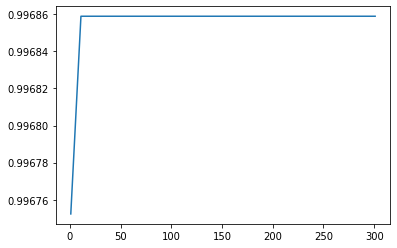

In [40]:
plt.plot(temp_test_acc['ntree'], temp_test_acc['score'])

Теперь проверим нашу модель на параметре - max_samples(максимальная выборка). Для него аналогично сгенерируем массив значений с 1 до 30 с шагом - 3. 

In [41]:
max_samples_grid = [i for i in range(1, 30, 3)]

temp_test_acc = pd.DataFrame(columns=['sample', 'score'])
for max_samples in max_samples_grid:
    rfc = BaggingClassifier(n_estimators=11, n_jobs=-1, oob_score=True, max_samples=max_samples)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    temp_test_acc = temp_test_acc.append({'sample': max_samples, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
temp_test_acc

C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,sample,score
0,1.0,0.565352
1,4.0,0.984241
2,7.0,0.994942
3,10.0,0.967577
4,13.0,0.995847
5,16.0,0.995847
6,19.0,0.995847
7,22.0,0.995847
8,25.0,0.995847
9,28.0,0.995847


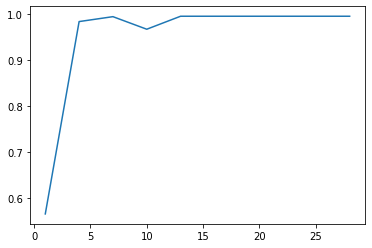

In [43]:
plt.plot(temp_test_acc['sample'], temp_test_acc['score'])

После построения графика мы выяснили, что лучшая точность получилась на значении 13.

In [44]:
rfc = BaggingClassifier(n_estimators=11, n_jobs=-1, oob_score=True, max_samples=13)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9675770643667145

Мы применили эти параметры на нашей готовой модели, чтобы проверить ее точность. В результате получили - 0.967

Перейдем к следующему алгоритму классификации - Random forest или случайный лес.

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Но метод случайных подпространств - **RandomForest**, позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом

Аналогично работе с Бэггингом сгенерируем массив деревьев от 1 до 301 с шагом 10, после чего найдем число деревьев, при котором точность наилучшая.

In [46]:
trees_grid = [i for i in range(1, 302, 10)]

temp_test_acc = pd.DataFrame(columns=['ntree', 'score'])
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    temp_test_acc = temp_test_acc.append({'ntree': ntrees, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
temp_test_acc

C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Nastya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some 

,ntree,score
0,1.0,0.996859
1,11.0,0.996859
2,21.0,0.996859
3,31.0,0.996912
4,41.0,0.996912
5,51.0,0.996912
6,61.0,0.996912
7,71.0,0.996859
8,81.0,0.996859
9,91.0,0.996859


 В данном случае это леса из 31-61 дерева. Возьмем лес из 31 дерева.

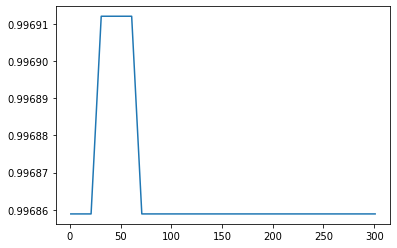

In [47]:
plt.plot(temp_test_acc['ntree'], temp_test_acc['score'])

Так же как и при работе с Бэггингом проверим нашу модель на параметре - depth(глубина). Для него сгенерируем массив значений от 3 до 30 с шагом 3. 

In [48]:
max_depth_grid = [i for i in range(3, 30, 3)]

temp_test_acc = pd.DataFrame(columns=['depth', 'score'])
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=31, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    rfc.fit(X_train, y_train)
    rfc.score(X_test, y_test)
    temp_test_acc = temp_test_acc.append({'depth': max_depth, 'score': rfc.score(X_test, y_test)}, ignore_index=True)
temp_test_acc

C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: 

,depth,score
0,3.0,0.996912
1,6.0,0.996912
2,9.0,0.996912
3,12.0,0.996912
4,15.0,0.996912
5,18.0,0.996912
6,21.0,0.996912
7,24.0,0.996912
8,27.0,0.996912


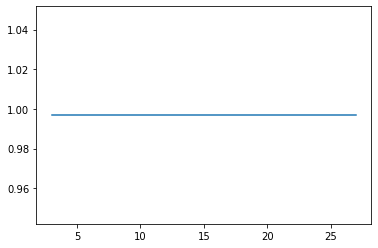

In [49]:
plt.plot(temp_test_acc['depth'], temp_test_acc['score'])

По графику видно, что точность одинакова при любом значении. 

Опять же применим эти параметры на нашей готовой модели, чтобы проверить ее точность. 

In [50]:
rfc = RandomForestClassifier(n_estimators=31, random_state=42, n_jobs=-1, oob_score=True, max_depth = 3)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

C:\Users\Nastya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9969121013682586

В результате получили точность, равную 0.997